In [47]:
import torch
import sys
sys.path.append('.')

import datetime
import matplotlib.pyplot as plt

['/home/yeji/Myenv/lib/python36.zip', '/home/yeji/Myenv/lib/python3.6', '/home/yeji/Myenv/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '', '/home/yeji/Myenv/local/lib/python3.6/site-packages', '/home/yeji/Myenv/lib/python3.6/site-packages', '/home/yeji/Myenv/local/lib/python3.6/site-packages/IPython/extensions', '/home/yeji/.ipython', '../', './model', '../', './model', '../', './model', '../', './model', '../', '../', '../', '../', '../', '../', '../', '../', '.', '.', '.']


In [42]:
# -*- coding:utf-8 -*-

"""
@author: Yeji Han

This script is used to preprocess the raw data file
"""

def load_criteo_category_index(file_path):
    f = open(file_path, 'r')
    cate_dict = []

    for i in range(39):
        cate_dict.append({})

    for line in f:
        data = line.strip().split(',')
        cate_dict[int(data[0])][data[1]] = int(data[2])

    return cate_dict

def read_criteo_data(file_path, emb_file):
    result = {'size': 0, 'label': [], 'index': [], 'value': [], 'feature_sizes':[]}
    cate_dict = load_criteo_category_index(emb_file)

    for item in cate_dict:
        result['feature_sizes'].append(len(item))

    f = open(file_path, 'r')
    for line in f:
        data = line.strip().split(',')
        result['label'].append(int(data[0]))
        indices = [int(item) for item in data[1:]]
        values = [1 for i in range(39)]
        result['index'].append(indices)
        result['value'].append(values)

    result['size'] += len(result['value'])

    return result

In [25]:
# -*- coding: utf-8 -*-

"""
@author: Yeji Han

A PyTorch implementation of Online FM
"""

from time import time
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score

import torch.backends.cudnn

class FM(torch.nn.Module):
    def __init__(self, field_size, feature_sizes, embedding_size=4, is_shallow_dropout=True,
                 dropout_shallow=[0.5], n_epochs=64, batch_size=256, interaction_type=True,
                 verbose=False, random_seed=990211, weight_decay=0.0, loss_type='logloss',
                 b=0.99, n=0.01, eval_metric=roc_auc_score, use_cuda=True, greater_is_better=True):
        super(FM, self).__init__()

        # Check CUDA
        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA")

        self.device = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.field_size = field_size
        self.feature_sizes = feature_sizes
        self.embedding_size = embedding_size
        self.is_shallow_dropout = is_shallow_dropout
        self.dropout_shallow = dropout_shallow
        self.batch_size = batch_size
        self.interaction_type = interaction_type
        self.n = n
        self.verbose = verbose
        self.weight_decay = weight_decay
        self.random_seed = random_seed
        self.loss_type = loss_type
        self.eval_metric = eval_metric
        self.use_cuda = use_cuda
        self.greater_is_better = greater_is_better

        self.b = Parameter(torch.tensor(b), requires_grad=False).to(self.device)

        # FM
        self.first_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, 1)
                                                     for feature_size in self.feature_sizes]).to(self.device)
        if self.dropout_shallow:
            self.first_order_dropout = nn.Dropout(self.dropout_shallow[0]).to(self.device)

        self.second_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, self.embedding_size)
                                                      for feature_size in self.feature_sizes]).to(self.device)

    def forward(self, Xi, Xv):
        first_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                               for i, emb in enumerate(self.first_order_embeddings)]
        first_order = torch.cat(first_order_emb_arr, 1)

        if self.dropout_shallow:
            first_order = self.first_order_dropout(first_order)

        if self.interaction_type:
            # Use 2xixj = (xi+xj)^2 - xi^2 - yj^2 to reduce calculation
            second_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                                    for i, emb in enumerate(self.second_order_embeddings)]
            sum_second_order_emb = sum(second_order_emb_arr)
            # (xi+xj)^2
            sum_second_order_emb_square = sum_second_order_emb * sum_second_order_emb
            # xi^2+xj^2
            second_order_emb_square = [item * item for item in second_order_emb_arr]
            second_order_emb_square_sum = sum(second_order_emb_square)
            second_order = (sum_second_order_emb_square - second_order_emb_square_sum) * 0.5

        else:
            second_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                                    for i, emb in enumerate(self.second_order_embeddings)]
            weights_fm = []
            for i in range(self.field_size):
                for j in range(i + 1, self.field_size):
                    weights_fm.append(second_order_emb_arr[i] * second_order_emb_arr[j])

        total_sum = self.b + torch.sum(first_order, 1) + torch.sum(second_order, 1)
        return total_sum

    def fit(self, Xi, Xv, Y):
        Xi = Variable(torch.LongTensor(Xi).reshape(-1, self.field_size, 1)).to(self.device)
        Xv = Variable(torch.FloatTensor(Xv).reshape(-1, self.field_size)).to(self.device)
        Y = Variable(torch.FloatTensor(Y)).to(self.device)

        model = self.train()
        optimizer = torch.optim.SGD(self.parameters(), lr=self.n)
        criterion = F.binary_cross_entropy_with_logits

        optimizer.zero_grad()
        output = model(Xi, Xv)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()

    def predict(self, Xi_data, Xv_data):
        Xi = Variable(torch.LongTensor(Xi_data).reshape(-1, self.field_size, 1)).to(self.device)
        Xv = Variable(torch.FloatTensor(Xv_data).reshape(-1, self.field_size)).to(self.device)
        model = self.eval()
        output = model(Xi, Xv)
        pred = torch.sigmoid(output).cpu()

        return pred.data.numpy() > 0.5

    def roc_score(self, pred, train_Y):
        confusion_matrix = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
        for j in range(pred.shape[0]):
            if pred[j] == train_Y[j]:
                if train_Y[j] == 1:
                    confusion_matrix["tp"] += 1
                else:
                    confusion_matrix["tn"] += 1
            else:
                if train_Y[j] == 1:
                    confusion_matrix["fn"] += 1
                else:
                    confusion_matrix["fp"] += 1

        if confusion_matrix['tp'] + confusion_matrix['fp'] != 0:
            tpr = confusion_matrix['tp'] / (confusion_matrix['tp'] + confusion_matrix['fp'])
        else:
            tpr = 0

        if confusion_matrix['fp'] + confusion_matrix['tn'] != 0:
            fpr = confusion_matrix['fp'] / (confusion_matrix['fp'] + confusion_matrix['tn'])
        else:
            fpr = 0

        return {"tpr": tpr, "fpr": fpr}

    def evaluate(self, train_Xi, train_Xv, train_Y):
        train_size = len(train_Y)
        time_elapsed = 0
        roc = []

        start = time()
        for i in range(train_size):
            end = i + self.batch_size

            if end < train_size:
                self.fit(train_Xi[i:end], train_Xv[i:end], train_Y[i:end])
            else:
                self.fit(train_Xi[i:train_size], train_Xv[i:train_size], train_Y[i:train_size])

            pred = self.predict(train_Xi, train_Xv)

            if i % 1000 == 0:
                roc.append(self.roc_score(pred, train_Y))

        time_elapsed = time() - start
        return time_elapsed, roc

In [26]:
# -*- coding:utf-8 -*-

"""
@author: Yeji Han

A PyTorch Implementation of Online NFM with Hedge Backpropagation
"""

import numpy as np
from time import time

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score

import torch.backends.cudnn

class ONN_NFM(torch.nn.Module):
    def __init__(self, field_size, feature_sizes, max_num_hidden_layers, qtd_neuron_per_hidden_layer,
                 dropout_shallow=[0.5], embedding_size=4, n_classes=2, batch_size=1,
                 verbose=False, interaction_type=True, eval_metric=roc_auc_score,
                 b=0.99, n=0.01, s=0.2, use_cuda=True, greater_is_better=True):
        super(ONN_NFM, self).__init__()

        # Check CUDA
        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA")

        self.device = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.field_size = field_size
        self.feature_sizes = feature_sizes
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.dropout_shallow = dropout_shallow
        self.embedding_size = embedding_size
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.verbose = verbose
        self.interaction_type = interaction_type
        self.eval_metric = eval_metric
        self.use_cuda = use_cuda
        self.greater_is_better = greater_is_better

        self.b = Parameter(torch.tensor(b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(s), requires_grad=False).to(self.device)

        # FM Part
        print("Initializing FM")
        self.first_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, 1)
                                                     for feature_size in self.feature_sizes]).to(self.device)
        if self.dropout_shallow:
            self.first_order_dropout = nn.Dropout(self.dropout_shallow[0]).to(self.device)
        self.second_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, self.embedding_size)
                                                      for feature_size in self.feature_sizes]).to(self.device)
        self.bias = Parameter(torch.randn(1)).to(self.device)
        print("Initializing FM Done")

        # Neural Networks Part
        print("Initializing Neural Networks")

        self.hidden_layers = []
        self.output_layers = []

        if self.interaction_type:
            self.hidden_layers.append(nn.Linear(embedding_size, qtd_neuron_per_hidden_layer))
        else:
            self.hidden_layers.append(
                nn.Linear(self.field_size * (self.field_size - 1) / 2, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(self.device)

        self.loss_array = []

        print("Initializing Neural Networks Done")

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def second_order(self, Xi, Xv):
        # FM Part
        Xi = torch.LongTensor(Xi).to(self.device).reshape(-1, self.field_size, 1)
        Xv = torch.FloatTensor(Xv).to(self.device).reshape(-1, self.field_size)
        second_order_emb_arr = [torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i].t()
                                for i, emb in enumerate(self.second_order_embeddings)]
        sum_second_order_emb = sum(second_order_emb_arr)
        # (xi+xj)^2
        sum_second_order_emb_square = sum_second_order_emb * sum_second_order_emb
        # xi^2+xj^2
        second_order_emb_square = [item * item for item in second_order_emb_arr]
        second_order_emb_square_sum = sum(second_order_emb_square)
        second_order = (sum_second_order_emb_square - second_order_emb_square_sum) * 0.5

        return second_order.t()

    def forward(self, Xi, Xv):
        # Neural Networks Part
        x = self.second_order(Xi, Xv)

        hidden_connections = []
        activation = F.relu

        x = activation(self.hidden_layers[0](x))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []
        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)
        return pred_per_layer

    def update_weights(self, Xi, Xv, Y, show_loss):
        Y = torch.from_numpy(Y).to(self.device)
        predictions_per_layer = self.forward(Xi, Xv)

        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes),
                             Y.view(self.batch_size).long())
            losses_per_layer.append(loss)

        w = []
        b = []

        for i in range(len(losses_per_layer)):
            losses_per_layer[i].backward(retain_graph=True)
            self.output_layers[i].weight.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].weight.grad.data
            self.output_layers[i].bias.data -= self.n * \
                                               self.alpha[i] * self.output_layers[i].bias.grad.data
            w.append(self.alpha[i] * self.hidden_layers[i].weight.grad.data)
            b.append(self.alpha[i] * self.hidden_layers[i].bias.grad.data)
            self.zero_grad()

        for i in range(1, len(losses_per_layer)):
            self.hidden_layers[i].weight.data -= self.n * torch.sum(torch.cat(w[i:]))
            self.hidden_layers[i].bias.data -= self.n * torch.sum(torch.cat(b[i:]))

        for i in range(len(losses_per_layer)):
            self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
            self.alpha[i] = torch.max(self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(self.alpha / z_t, requires_grad=False).to(self.device)

        if show_loss:
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            if (len(self.loss_array) % 1000) == 0:
                print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                self.loss_array.clear()

    def partial_fit_(self, Xi_data, Xv_data, Y_data, show_loss=False):
        self.update_weights(Xi_data, Xv_data, Y_data, show_loss)

    def partial_fit(self, Xi_data, Xv_data, Y_data, show_loss=False):
        self.partial_fit_(Xi_data, Xv_data, Y_data, show_loss)

    def predict_(self, Xi_data, Xv_data):
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(Xi_data)).view(
                self.max_num_hidden_layers, len(Xi_data), 1), self.forward(Xi_data, Xv_data)), 0), dim=1).cpu().numpy()

    def predict(self, Xi_data, Xv_data):
        pred = self.predict_(Xi_data, Xv_data)
        return pred

    def roc_score(self, pred, train_Y):
        confusion_matrix = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

        for j in range(pred.shape[0]):
            if pred[j] == train_Y[j]:
                if train_Y[j] == 1:
                    confusion_matrix["tp"] += 1
                else:
                    confusion_matrix["tn"] += 1
            else:
                if train_Y[j] == 1:
                    confusion_matrix["fn"] += 1
                else:
                    confusion_matrix["fp"] += 1

        if confusion_matrix['tp'] + confusion_matrix['fp'] != 0:
            tpr = confusion_matrix['tp'] / (confusion_matrix['tp'] + confusion_matrix['fp'])
        else:
            tpr= 0

        if confusion_matrix['fp'] + confusion_matrix['tn'] != 0:
            fpr = confusion_matrix['fp'] / (confusion_matrix['fp'] + confusion_matrix['tn'])
        else:
            fpr = 0

        return {"tpr": tpr, "fpr": fpr}

    def evaluate(self, train_Xi, train_Xv, train_Y):
        roc = []
        time_elapsed = 0

        start = time()
        for i in range(len(train_Y)):
            self.partial_fit(np.array(train_Xi[i]), np.array(train_Xv[i]), np.array(train_Y[i]))
            pred = self.predict(train_Xi, train_Xv)

            if i % 1000 == 0:
                roc.append(self.roc_score(pred, train_Y))

        time_elapsed = time() - start
        return time_elapsed, roc
    

In [43]:
# -*- coding: utf-8 -*-

"""
@author: Yeji Han

A PyTorch implementation of Online NFM with SGD
"""

from sklearn.metrics import accuracy_score
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.backends.cudnn
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score


class SGD_NFM(torch.nn.Module):
    def __init__(self, field_size, feature_sizes, max_num_hidden_layers, qtd_neuron_per_hidden_layer,
                 dropout_shallow=[0.5], embedding_size=4, n_classes=2, n_epochs=64, batch_size=100,
                 loss_type='logloss', verbose=False, interaction_type=True, eval_metric=accuracy_score,
                 b=0.99, n=0.01, s=0.2, use_cuda=True, greater_is_better=True):

        super(SGD_NFM, self).__init__()

        # Check CUDA
        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA")

        self.device = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.field_size = field_size
        self.feature_sizes = feature_sizes
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.dropout_shallow = dropout_shallow
        self.embedding_size = embedding_size
        self.n_epochs = n_epochs
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.verbose = verbose
        self.interaction_type = interaction_type
        self.eval_metric = eval_metric
        self.use_cuda = use_cuda
        self.greater_is_better = greater_is_better
        self.n = n

        self.b = Parameter(torch.tensor(b), requires_grad=False).to(self.device)

        # FM part
        self.first_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, 1)
                                                     for feature_size in self.feature_sizes]).to(self.device)
        if self.dropout_shallow:
            self.first_order_dropout = nn.Dropout(self.dropout_shallow[0]).to(self.device)

        self.second_order_embeddings = nn.ModuleList([nn.Embedding(feature_size, self.embedding_size)
                                                      for feature_size in self.feature_sizes]).to(self.device)

        # Neural Networks
        self.hidden_layers = []

        if self.interaction_type:
            self.hidden_layers.append(nn.Linear(embedding_size, qtd_neuron_per_hidden_layer))
        else:
            self.hidden_layers.append(
                nn.Linear(self.field_size * (self.field_size - 1) / 2, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)

    def forward(self, Xi, Xv):
        # FM
        first_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                               for i, emb in enumerate(self.first_order_embeddings)]
        first_order = torch.cat(first_order_emb_arr, 1)

        if self.dropout_shallow:
            first_order = self.first_order_dropout(first_order)

        if self.interaction_type:
            # Use 2xixj = (xi+xj)^2 - xi^2 - yj^2 to reduce calculation
            second_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                                    for i, emb in enumerate(self.second_order_embeddings)]
            sum_second_order_emb = sum(second_order_emb_arr)
            # (xi+xj)^2
            sum_second_order_emb_square = sum_second_order_emb * sum_second_order_emb
            # xi^2+xj^2
            second_order_emb_square = [item * item for item in second_order_emb_arr]
            second_order_emb_square_sum = sum(second_order_emb_square)
            second_order = (sum_second_order_emb_square - second_order_emb_square_sum) * 0.5

        else:
            second_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t()
                                    for i, emb in enumerate(self.second_order_embeddings)]
            weights_fm = []
            for i in range(self.field_size):
                for j in range(i + 1, self.field_size):
                    weights_fm.append(second_order_emb_arr[i] * second_order_emb_arr[j])

        # Neural Networks
        if self.interaction_type:
            x = second_order
        else:
            x = torch.cat([torch.sum(weight_fm, 1).view([-1, 1])
                           for weight_fm in weights_fm], 1)

        activation = F.relu
        for i in range(self.max_num_hidden_layers):
            x = activation(self.hidden_layers[i](x))

        # Sum
        total_sum = self.b + torch.sum(first_order, 1) + torch.sum(x, 1)
        return total_sum

    def fit(self, Xi, Xv, Y):
        Xi = Variable(torch.LongTensor(Xi).reshape(-1, self.field_size, 1)).to(self.device)
        Xv = Variable(torch.FloatTensor(Xv).reshape(-1, self.field_size)).to(self.device)
        Y = Variable(torch.FloatTensor(Y)).to(self.device)

        model = self.train()
        optimizer = torch.optim.SGD(self.parameters(), lr=self.n)
        criterion = F.binary_cross_entropy_with_logits

        epoch_begin_time = time()

        optimizer.zero_grad()
        output = model(Xi, Xv)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()

    def predict(self, Xi_data, Xv_data):
        Xi = Variable(torch.LongTensor(Xi_data).reshape(-1, self.field_size, 1)).to(self.device)
        Xv = Variable(torch.FloatTensor(Xv_data).reshape(-1, self.field_size)).to(self.device)

        model = self.eval()
        output = model(Xi, Xv)
        pred = torch.sigmoid(output).cpu()
        return pred.data.numpy() > 0.5

    def roc_score(pred, train_Y):
        confusion_matrix = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

        for j in range(pred):
            if pred[j] == train_Y[j]:
                if train_Y[j] == 1:
                    confusion_matrix["tp"] += 1
                else:
                    confusion_matrix["tn"] += 1
            else:
                if train_Y[j] == 1:
                    confusion_matrix["fn"] += 1
                else:
                    confusion_matrix["fp"] += 1

        tpr = confusion_matrix['tp'] / (confusion_matrix['tp'] + confusion_matrix['fp'])
        fpr = confusion_matrix['fp'] / (confusion_matrix['fp'] + confusion_matrix['tn'])

        return {"tpr": tpr, "fpr": fpr}

    def roc_score(self, pred, train_Y):
        confusion_matrix = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

        for j in range(pred.shape[0]):
            if pred[j] == train_Y[j]:
                if train_Y[j] == 1:
                    confusion_matrix["tp"] += 1
                else:
                    confusion_matrix["tn"] += 1
            else:
                if train_Y[j] == 1:
                    confusion_matrix["fn"] += 1
                else:
                    confusion_matrix["fp"] += 1

        if confusion_matrix['tp'] + confusion_matrix['fp'] != 0:
            tpr = confusion_matrix['tp'] / (confusion_matrix['tp'] + confusion_matrix['fp'])
        else:
            tpr = 0

        if confusion_matrix['fp'] + confusion_matrix['tn'] != 0:
            fpr = confusion_matrix['fp'] / (confusion_matrix['fp'] + confusion_matrix['tn'])
        else:
            fpr = 0

        return {"tpr": tpr, "fpr": fpr}

    def evaluate(self, train_Xi, train_Xv, train_Y):
        train_size = len(train_Y)
        time_elapsed = 0
        confusion_matrix = {
            "tp": 0, "fp": 0, "tn": 0, "fn": 0
        }
        roc = []

        start = time()
        for i in range(train_size):
            end = i + self.batch_size
            if end < train_size:
                self.fit(train_Xi[i:end], train_Xv[i:end], train_Y[i:end])
            else:
                self.fit(train_Xi[i:train_size], train_Xv[i:train_size], train_Y[i:train_size])

            pred = self.predict(train_Xi, train_Xv)

            if i % 1000 == 0:
                roc.append(self.roc_score(pred, train_Y))


        time_elapsed = time() - start
        return time_elapsed, roc

In [45]:
print("===== Importing Dataset =====")

train_dict = read_criteo_data('tiny_train_input.csv', 'category_emb.csv')
train_dict_size = train_dict['size']

train_Xi, train_Xv, train_Y \
    = train_dict['index'][:int(train_dict_size * 0.05)], \
      train_dict['value'][:int(train_dict_size * 0.05)], \
      train_dict['label'][:int(train_dict_size * 0.05)]

print("===== Dataset is Ready =====")

# with torch.cuda.device(0):
time_elapsed = {"FM": 0, "SGD_NFM": 0, "ONN_NFM": 0}
roc_scores = {"FM": [], "SGD_NFM": [], "ONN_NFM": []}

print("===== Instantiating Models =====")

fm = FM(39, train_dict['feature_sizes'], batch_size=20)
sgd_nfm = SGD_NFM(39, train_dict['feature_sizes'], 5, 10, batch_size=20)
onn_nfm = ONN_NFM(39, train_dict['feature_sizes'], max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=10,
                  verbose=True, use_cuda=True, interaction_type=True)

models = [(fm, "FM"), (sgd_nfm, "SGD_NFM"), (onn_nfm, "ONN_NFM")]

print("===== Models are Ready =====")

===== Importing Dataset =====


FileNotFoundError: [Errno 2] No such file or directory: 'data/category_emb.csv'

In [30]:
print(f"===== Training FM =====")
time_elapsed[models[0][1]], roc_scores[models[0][1]] = models[0][0].evaluate(train_Xi, train_Xv, train_Y)
print(f"===== Evaluating FM is Finished. Time: {time_elapsed[models[0][1]]} =====")

===== Training FM =====


NameError: name 'models' is not defined

In [ ]:
print(f"===== Training SGD_NFM =====")
time_elapsed[models[1][1]], roc_scores[models[1][1]] = models[1][0].evaluate(train_Xi, train_Xv, train_Y)
print(f"===== Evaluating SGD_NFM is Finished. Time: {time_elapsed[models[1][1]]} =====")

In [ ]:
print(f"===== Training ONN_NFM =====")
time_elapsed[models[2][1]], roc_scores[models[2][1]] = models[2][0].evaluate(train_Xi, train_Xv, train_Y)
print(f"===== Evaluating ONN_NFM is Finished. Time: {time_elapsed[models[2][1]]} =====")

===== Drawing a plot =====


AttributeError: 'AxesSubplot' object has no attribute 'ylim'

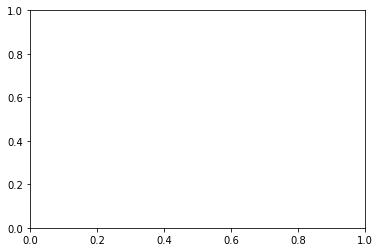

In [48]:
print("===== Drawing a plot =====")

now = datetime.datetime.now()
date = now.strftime('%Y-%m-%d')

fig, ax = plt.subplots()

ax.ylim(-0.04, 1.04)
ax.xlabel('FPR')
ax.ylabel('TPR')

for i, (mark, color) in enumerate(zip(
        ['s', 'o', 'v'], ['r', 'g', 'b'])):
    ax.plot(roc_scores[i]['fpr'], roc_scores[i]['tpr'], color=color,
            marker=mark,
            markerfacecolor='None',
            markeredgecolor=color,
            linestyle='None',
            label=models[i][1])

ax.set_aspect('equal')
ax.title(f'ROC Score (Dataset #: {len(train_Y)}')
ax.legend(loc='lower right')
fig.savefig(f'{date}_roc_score.png')

print("===== Drawing Plot is Finished=====")

plt.show()
